In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline 

import cv2
import os

from fastai.vision import *
from fastai.metrics import error_rate

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/digit-recognizer/test.csv
/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels.h5
/kaggle/input/resnet50/imagenet_class_index.json
/kaggle/input/resnet50/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5


In [3]:
train = pd.read_csv('../input/digit-recognizer/train.csv' , encoding='latin1')
test  = pd.read_csv('../input/digit-recognizer/test.csv')
sub =   pd.read_csv('../input/digit-recognizer/sample_submission.csv')

Take a look at the dataset

In [4]:
train.tail()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41999,9,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Create an image from ds

In [5]:
class CustomImageList(ImageList):
    def open(self, fn):
        img = fn.reshape(28,28)
#         img = np.stack((img,)*3, axis=-1)
        return Image(pil2tensor(img, dtype=np.float32))
    
    @classmethod
    def from_csv_custom(cls, path:PathOrStr, csv_name:str, imgIdx:int=1, header:str='infer', **kwargs)->'ItemList': 
        df = pd.read_csv(Path(path)/csv_name, header=header)
        res = super().from_df(df, path=path, cols=0, **kwargs)
        
        res.items = df.iloc[:,imgIdx:].apply(lambda x: x.values / 255.0, axis=1).values
        
        return res

**Dataloader**

In [6]:
tfms = get_transforms(do_flip=False )
data = (CustomImageList.from_csv_custom(path='../input/digit-recognizer/', csv_name='train.csv', imgIdx=1 , convert_mode='binary')
                .split_by_rand_pct(.2)
                .label_from_df(cols='label')
                .add_test(test)
                .transform(tfms)
                .databunch(bs=128, num_workers=0)
                .normalize(imagenet_stats))

**Shows example**

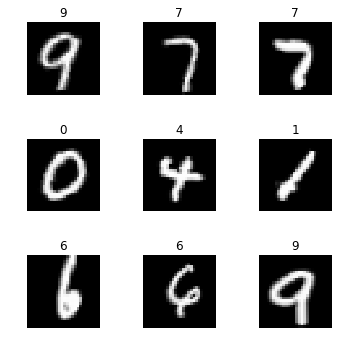

In [7]:
data.show_batch(rows=3, figsize=(5,5))

**Create a learner**

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/checkpoints/resnet50-19c8e357.pth


epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-03
Min loss divided by 10: 3.63E-02


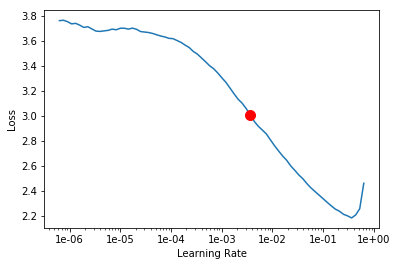

In [8]:
learn = cnn_learner(data, models.resnet50, metrics=accuracy, model_dir='/kaggle/working/models')
learn.lr_find()
learn.recorder.plot(suggestion=True)

**Train the last layers**

In [9]:
learn.fit_one_cycle(1,2e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.152081,0.058823,0.981310,01:04


In [10]:
learn.save('one_epoch')

Let's try to have a bigger accuracy

In [11]:
learn.fit_one_cycle(10,slice(1e-3,1e-2))

epoch,train_loss,valid_loss,accuracy,time
0,0.099096,0.047306,0.984881,01:04
1,0.103607,0.057561,0.982857,01:03
2,0.095100,0.046811,0.986071,01:03
3,0.084136,0.031321,0.990357,01:03
4,0.060831,0.049940,0.985833,01:03
5,0.058430,0.032122,0.990357,01:02
6,0.044663,0.023420,0.993214,01:03
7,0.034576,0.024391,0.993929,01:03
8,0.025354,0.021123,0.993452,01:03
9,0.027808,0.021354,0.993333,01:03


In [12]:
learn.save('second_epoch')

**Train all the layers**

In [13]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


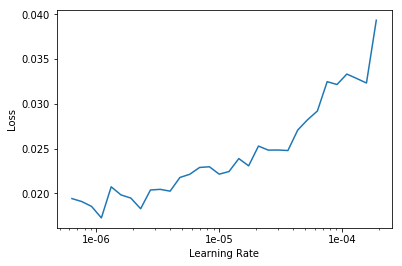

In [14]:
learn.lr_find()
learn.recorder.plot()

In [15]:
learn.load('second_epoch')

Learner(data=ImageDataBunch;

Train: LabelList (33600 items)
x: CustomImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
0,4,0,7,3
Path: ../input/digit-recognizer;

Valid: LabelList (8400 items)
x: CustomImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: CategoryList
9,7,3,0,4
Path: ../input/digit-recognizer;

Test: LabelList (28000 items)
x: CustomImageList
Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28),Image (1, 28, 28)
y: EmptyLabelList
,,,,
Path: ../input/digit-recognizer, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        

In [16]:
learn.fit_one_cycle(8, max_lr=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.022113,0.021486,0.993690,01:08
1,0.027897,0.020099,0.994405,01:08
2,0.025349,0.023140,0.993095,01:07
3,0.023557,0.023864,0.993333,01:07
4,0.019692,0.022503,0.992976,01:08
5,0.020028,0.022544,0.993333,01:11
6,0.017911,0.021098,0.993810,01:11
7,0.020356,0.022218,0.993333,01:11


In [17]:
learn.save('third_step')

Show images in top_losses along with their prediction, actual, loss, and probability of actual class.

In [18]:
preds,y,losses = learn.get_preds(with_loss=True)
interp = ClassificationInterpretation(learn, preds, y, losses)

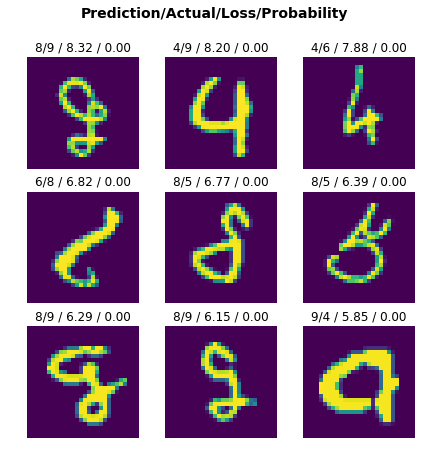

In [19]:
interp.plot_top_losses(9, figsize=(7,7))

it's easy to understand why the computer had a dificuly to distinguish between the numbers, 
to increase the next step would be to erase this images and retrain the model to make it more accurate

**Submission**

In [20]:
# get the predictions
predictions, *_ = learn.get_preds(DatasetType.Test)
labels = np.argmax(predictions, 1)
# output to a file
submission_df = pd.DataFrame({'ImageId': list(range(1,len(labels)+1)), 'Label': labels})
submission_df.to_csv(f'submission.csv', index=False)